# Organizing clusters as a hierarchical tree

One advantage of hierarchical clustering algorithms is that it allows us to plot dendrograms (visualizations of a binary hierarchical clustering), which can help with the interpretation of the results by creating meaningful taxonomies. Another useful advantage of this hierarchical approach is that we do not need to specify the number of clusters up front.

The two main approaches to hierarchical clustering are agglomerative and divisive hierarchical clustering. In divisive hierarchical clustering, we start with one cluster that encompasses all our samples, and we iteratively split the cluster into smaller clusters until each cluster only contains one sample.

## Grouping clusters in bottom-up fashion

The two standard algorithms for agglomerative hierarchical clustering are single linkage and complete linkage. Using single linkage, we compute the distances between the most similar members for each pair of clusters and merge the two clusters for which the distance between the most similar members is the smallest. The complete linkage approach is similar to single linkage but, instead of comparing the most similar members in each pair of clusters, we compare the most dissimilar members to perform the merge.

<img src="img/fig1.jpeg">

Hierarchical complete linkage clustering is an iterative procedure that can be summarized by the following steps:

  1. Compute the distance matrix of all samples.
  2. Represent each data point as a singleton cluster.
  3. Merge the two closest clusters based on the distance between the most dissimilar (distant) members.
  4. Update the similarity matrix.
  5. Repeat steps 2-4 until one single cluster remains.

In [1]:
# random sample data
# the rows represent different observations (IDs 0-4),
# and the columns are the different features (X, Y, Z) of those samples
import pandas as pd
import numpy as np

np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


## Performing hierarchical clustering on a distance matrix

To calculate the distance matrix as input for the hierarchical clustering algorithm, we will use the `pdist` function from SciPy's `spatial.distance` submodule:

In [2]:
# calculate the distance matrix
# Euclidean distance between each pair of sample points
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                       columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


We provided the condensed distance matrix—returned by pdist—as input to the squareform function to create a symmetrical matrix of the pair-wise distances.

In [3]:
# before we call the linkage function, let us take a careful look at the function documentation
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1d condensed distance matrix
    or a 2d array of observation vectors.
    
    If y is a 1d condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the n

In [4]:
# Next, we will apply the complete linkage agglomeration to our clusters
row_clusters = linkage(df.values,
                      method='complete',
                      metric='euclidean')

In [5]:
# To take a closer look at the clustering results, we can turn clustering results into a pandas DataFrame
pd.DataFrame(row_clusters,
            columns=['row label 1',
                    'row label 2',
                    'distance',
                    'no. of items in clust.'],
            index=['cluster %d' % (i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


Now that we have computed the linkage matrix, we can visualize the results in the form of a dendrogram.

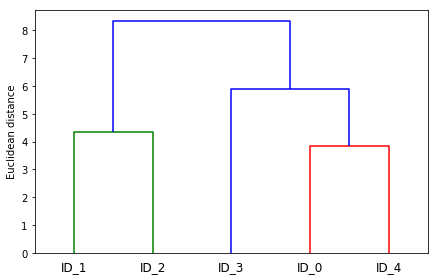

In [7]:
# making a dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
# make dendrogram black (pat 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])
row_dendr = dendrogram(row_clusters,
                      labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                      )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

Such a dendrogram summarizes the different clusters that were formed during the agglomerative hierarchical clustering; for example, we can see that the samples `ID_0` and `ID_4`, followed by `ID_1` and `ID_2`, are the most similar ones based on the Euclidean distance metric.

## Attaching dendrograms to a heat map

In practical applications, hierarchical clustering dendrograms are often used in combination with a heat map, which allows us to represent the individual values in the sample matrix with a color code. 

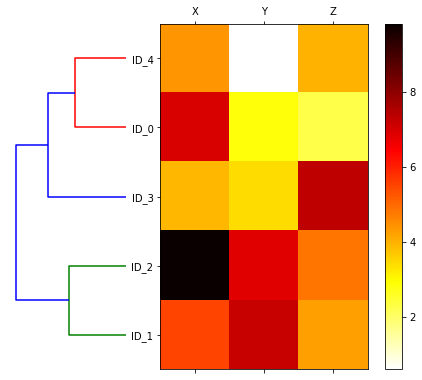

In [10]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')
# we reorder the data in our initial DataFrame according to the clustering labels 
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

# we construct the heat map
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')

# we will modify the aesthetics of the dendrogram by removing the axis ticks and hiding the axis spines.
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)

fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

As we can see, the order of rows in the heat map reflects the clustering of the samples in the dendrogram. In addition to a simple dendrogram, the color-coded values of each sample and feature in the heat map provide us with a nice summary of the dataset.

### Applying agglomerative clustering via scikit-learn

In the previous subsection, we saw how to perform agglomerative hierarchical clustering using SciPy. However, there is also an AgglomerativeClustering implementation in scikit-learn, which allows us to choose the number of clusters that we want to return. This is useful if we want to prune the hierarchical cluster tree. By setting the n_cluster parameter to 3, we will now cluster the samples into three groups using the same complete linkage approach based on the Euclidean distance metric, as before:

In [11]:
from sklearn.cluster import AgglomerativeClustering


ac = AgglomerativeClustering(n_clusters=3,
                            affinity='euclidean',
                            linkage='complete')

labels = ac.fit_predict(X)
print('Cluster labels = %s' % labels)

Cluster labels = [1 0 0 2 1]


Looking at the predicted cluster labels, we can see that the first and the fifth sample (ID_0 and ID_4) were assigned to one cluster (label 1), and the samples ID_1 and ID_2 were assigned to a second cluster (label 0). The sample ID_3 was put into its own cluster (label 2). Overall, the results are consistent with the results that we observed in the dendrogram. We shall note though that ID_3 is more similar to ID_4 and ID_0 than to ID_1 and ID_2, as shown in the preceding dendrogram figure; this is not clear from scikit-learn's clustering results. Let's now rerun the AgglomerativeClustering using n_cluster=2 in the following code snippet:

In [12]:
ac = AgglomerativeClustering(n_clusters=2,
                            affinity='euclidean',
                            linkage='complete')

labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


As we can see, in this pruned clustering hierarchy, label ID_3 was assigned to the same cluster as ID_0 and ID_4, as expected.